# Предсказание числа солненечных лучей

На сайте Королевской обсерватории Бельгии http://www.sidc.be/silso/datafiles размещены исторические данные о числе пятен на Солнце с 1 января 1818 года по настоящее время. Известно, что солнечная активность циклична с периодом около 11 лет. Кроме того, в солнечной активности существуют закономерности на бо́льших и меньших временных масштабах. Таким образом предсказание числа пятен на следующий день может опираться на данные за 22 прошедших года, то есть на более, чем 8000 известных значений. Построить нейронную сеть, решающую данную задачу.



In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from tensorflow.keras.metrics import RootMeanSquaredError

### Посмотрим на данные

В описании к dataset было написано следующее про колонки:

- [1-4] Year
- [6-7] Month
- [9-10] Day
- [12-19] Decimal date
- [22-24] Daily sunspot number
- [26-30] Standard deviation
- [33-35] Number of observations
- [37] Definitive/provisional indicator

Загрузим наш dataset, посмотрим на него:

In [2]:
df = pd.read_csv('./dataset.csv', sep=';', names=['year', 'month', 'day', 'dday', "sunspots", 'std', 'nof', 'dpi'])

In [3]:
df

,year,month,day,dday,sunspots,std,nof,dpi
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
74717,2022,7,27,2022.568,58,7.5,44,0
74718,2022,7,28,2022.571,42,7.9,48,0
74719,2022,7,29,2022.574,43,8.5,41,0
74720,2022,7,30,2022.577,43,5.3,36,0


In [4]:
df['date'] = df.apply(lambda row: '{}-{}-{}'.format(int(row['year']), int(row['month']), int(row['day'])), axis=1)
df['date'] = pd.to_datetime(df['date'])

In [5]:
dataset = df.drop(columns=['year', 'month', 'day', 'dday', 'std','nof', 'dpi'])

In [6]:
dataset[dataset.sunspots == -1].tail()

,sunspots,date
11296,-1,1848-12-05
11306,-1,1848-12-15
11307,-1,1848-12-16
11310,-1,1848-12-19
11313,-1,1848-12-22


У нас пропуски заканчиваются на `11313` строке, чтобы не думать о заполнении пропусков, т.к. данные выглядят очень зашумленными, отрежем первые `11314` строк.

In [7]:
slice_index = dataset.shape[0] - dataset[dataset.sunspots == -1].last_valid_index() - 1
slice_index

63408

In [8]:
Data = dataset.iloc[-slice_index:, :].reset_index(drop=True)
Data

,sunspots,date
0,353,1848-12-23
1,240,1848-12-24
2,275,1848-12-25
3,352,1848-12-26
4,268,1848-12-27
...,...,...
63403,58,2022-07-27
63404,42,2022-07-28
63405,43,2022-07-29
63406,43,2022-07-30


Посмотрим на данные на графике за последние 16к дней:

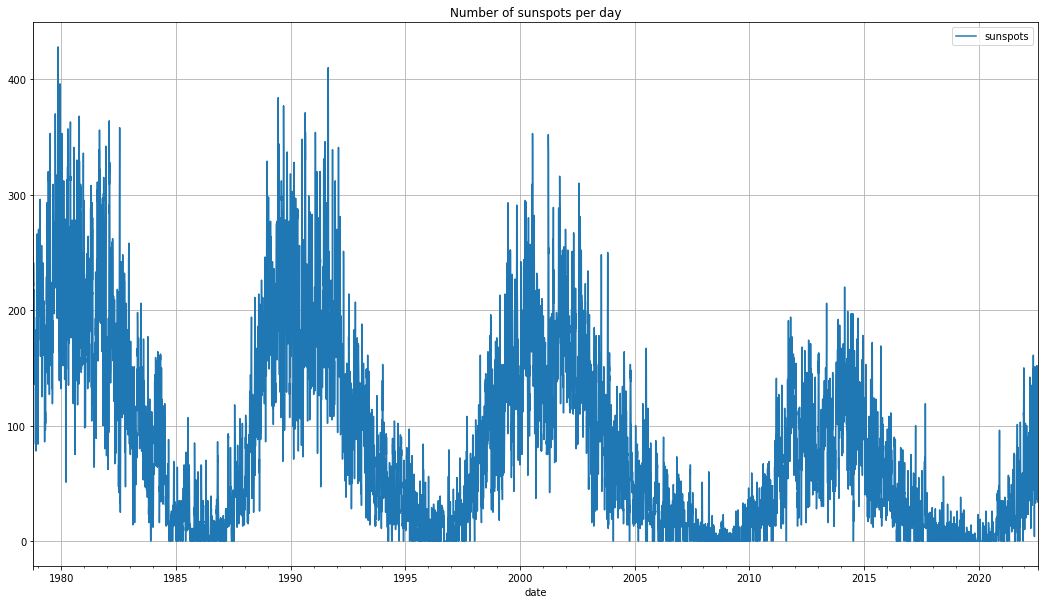

In [9]:
Data.iloc[-16000:, :].plot(y='sunspots', x='date', title='Number of sunspots per day', figsize=(18, 10))
plt.grid()

### Подготовка данных для обучения

In [12]:
series = np.array(Data['sunspots'])
time = np.array(Data['date'])

Разобьем данные на train, validation и test (на нем будем проверять нашу модель)

In [13]:
train_size = 48000
validation_size = 5000
test_size = len(series) - train_size - validation_size

[train, validation, test] = [series[0:train_size], series[train_size:train_size+validation_size], series[train_size+validation_size:len(series)]]
[time_train, time_validation, time_test] = [time[0:train_size], time[train_size:train_size+validation_size], time[train_size+validation_size:len(series)]]

print(len(train), len(validation), len(test),)

48000 5000 10408


In [14]:
window_size = 8000
window_step=4

kernel_size=5

Разобьем наши данные так, чтобы мы могли предсказывать следующее значение на основе предыдущих 8000 дней (окна):

In [15]:
def create_dataset(dataset, time, window_size=8000, step=window_step):
    dataX, dataY, date_array = [], [], []

    for i in range(0, len(dataset)-window_size-1, step):
        a = dataset[i:(i+window_size)]
        dataX.append(a)
        dataY.append(dataset[i + window_size])
        date_array.append(time[i + window_size])

    X = np.array(dataX)
    X = X.reshape(*X.shape, 1)
    return [np.array(dataX), np.array(dataY), np.array(date_array)]

In [45]:
[X_train, Y_train, train_date] = create_dataset(train, time_train, window_size)
[X_validation, Y_validation, _] = create_dataset(validation, time_validation, window_size)
[X_test, Y_test, date_test] = create_dataset(test, time_test, window_size, step=1)

In [17]:
X_train.shape, Y_train.shape

((10000, 8000), (10000,))

Напишем модель, которой на входной слой будет приходить вектор `8000 х 1`.

Далее будет сверточный слой, он сжимает входной вектор. Потому что LSTM будет долго работать с таким большим вектором.

Затем добавляем `LSTM` слой, который лучше всего находит закономерности во временных рядах.

Затем будут полносвязные слои, которые принимают на вход 64 нейрона, а на выход дают предсказание количества солнечных пятен.

In [18]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((window_size, 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=kernel_size, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8000, 64)          384       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 36,033
Trainable params: 36,033
Non-trainable params: 0
_________________________________________________________________


В качестве функции потерь выберем Huber loss function, которая на зашумленных данных работает лучше, чем MSE.

В качестве метрики качества предсказаний возьмем корень среднеквадратичной ошибки.

In [19]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=[RootMeanSquaredError()])

In [21]:
history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=10)

Epoch 1/10
313/313 [==============================] - 68s 216ms/step - loss: 30.4405 - root_mean_squared_error: 55.9576
Epoch 2/10
313/313 [==============================] - 66s 212ms/step - loss: 15.0567 - root_mean_squared_error: 24.1949
Epoch 3/10
313/313 [==============================] - 66s 211ms/step - loss: 14.8559 - root_mean_squared_error: 23.5068
Epoch 4/10
313/313 [==============================] - 66s 210ms/step - loss: 13.9853 - root_mean_squared_error: 21.7445
Epoch 5/10
313/313 [==============================] - 66s 212ms/step - loss: 14.0323 - root_mean_squared_error: 21.7188
Epoch 6/10
313/313 [==============================] - 67s 213ms/step - loss: 13.9481 - root_mean_squared_error: 21.5431
Epoch 7/10
313/313 [==============================] - 69s 220ms/step - loss: 13.6729 - root_mean_squared_error: 21.1453
Epoch 8/10
313/313 [==============================] - 66s 209ms/step - loss: 13.9031 - root_mean_squared_error: 21.4272
Epoch 9/10
313/313 [====================

In [25]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/sunspot_model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


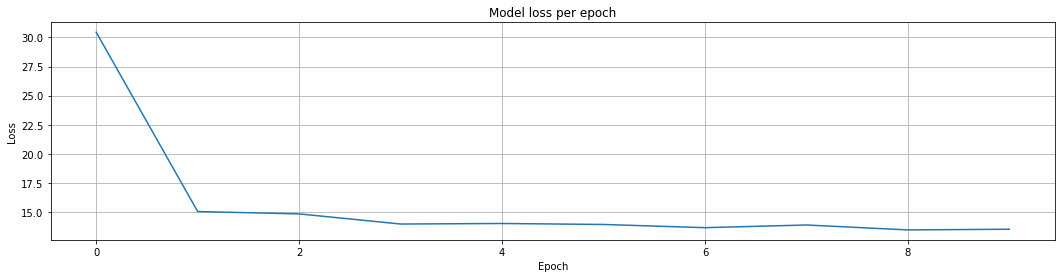

In [60]:
plt.figure(figsize=(18,4))
plt.plot(history.history['loss'])
plt.title('Model loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

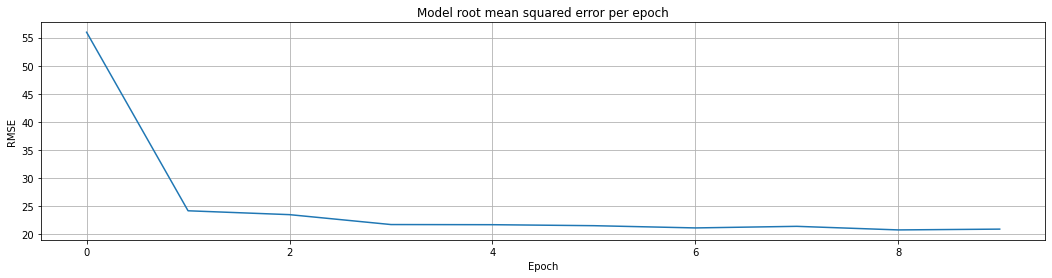

In [62]:
plt.figure(figsize=(18,4))
plt.plot(history.history['root_mean_squared_error'])
plt.title('Model root mean squared error per epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.grid()
plt.show()

Посмотрим на предсказание модели на обучающей выборке:

In [63]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Date': train_date, 'Prediction':train_predictions, 'Actual': Y_train,})
train_results

,Date,Prediction,Actual
0,1870-11-18,235.367783,197
1,1870-11-22,172.726028,172
2,1870-11-26,137.664047,92
3,1870-11-30,187.261459,205
4,1870-12-04,335.045319,347
...,...,...,...
9995,1980-05-05,228.426895,272
9996,1980-05-09,220.288315,238
9997,1980-05-13,204.098282,212
9998,1980-05-17,204.087234,245


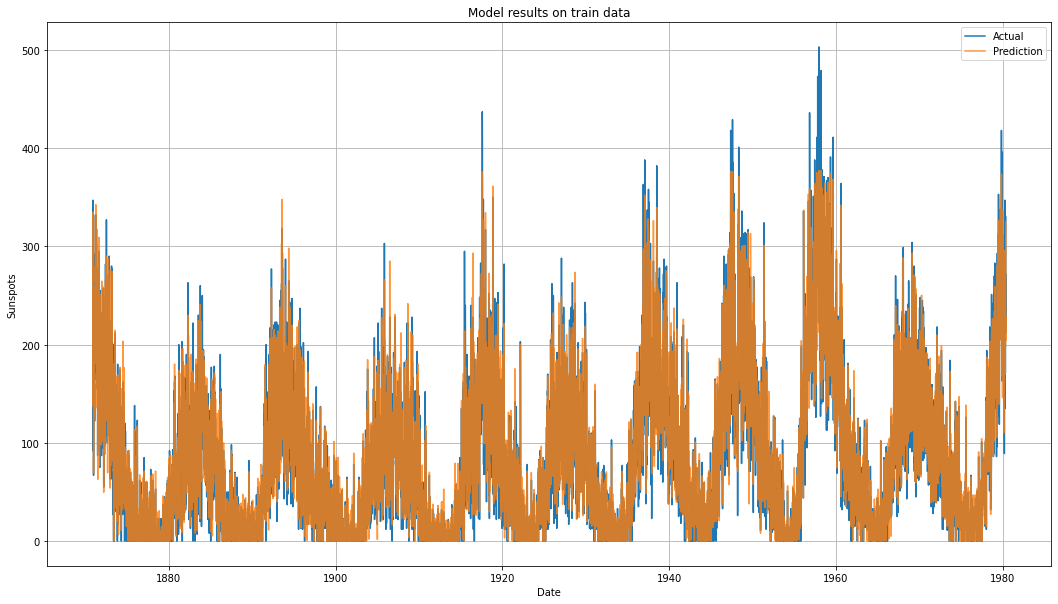

In [51]:
plt.figure(figsize=(18,10))
plt.plot(train_results['Date'], train_results['Actual'], label='Actual')
plt.plot(train_results['Date'], train_results['Prediction'], alpha=0.8, label='Prediction')
plt.title('Model results on train data')
plt.ylabel('Sunspots')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

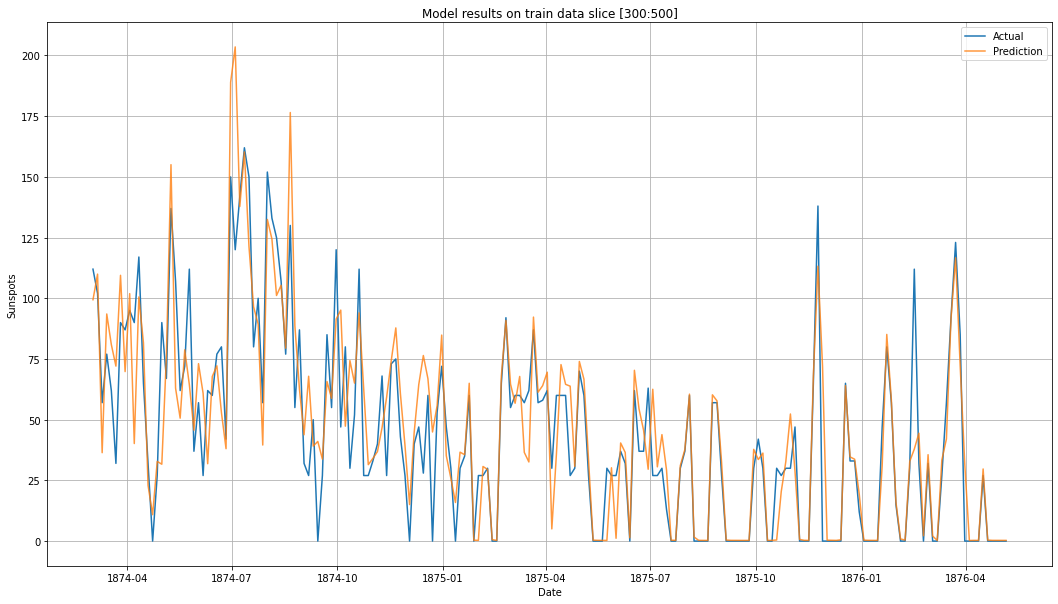

In [53]:
plt.figure(figsize=(18,10))
plt.plot(train_results['Date'][300:500], train_results['Actual'][300:500], label='Actual')
plt.plot(train_results['Date'][300:500], train_results['Prediction'][300:500], label='Prediction', alpha=0.8)

plt.title('Model results on train data slice [300:500]')
plt.ylabel('Sunspots')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

Посмотрим на то, как отработала наша модель на тестовой выборке:

In [64]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={"Date": date_test, 'Prediction':test_predictions, 'Actual': Y_test})

test_results

,Date,Prediction,Actual
0,2015-12-28,69.449570,71
1,2015-12-29,73.983299,57
2,2015-12-30,59.813328,37
3,2015-12-31,41.090340,22
4,2016-01-01,28.047617,37
...,...,...,...
2402,2022-07-26,86.966469,91
2403,2022-07-27,92.258888,58
2404,2022-07-28,62.684814,42
2405,2022-07-29,48.340195,43


Посмотрим на корень среднеквардратичной ошибки:

In [68]:
mean_squared_error(test_results['Actual'], test_results['Prediction'], squared=False)

9.215768386958457

In [66]:
def plot(df, title):
  plt.figure(figsize=(18,8))
  plt.plot(df['Date'], df['Prediction'], label='Prediction')
  plt.plot(df['Date'], df['Actual'], label='Actual')
  plt.title(title)
  plt.ylabel('Sunspots')
  plt.xlabel('Date')

  plt.grid()
  plt.legend()

Построим графики, чтобы увидеть, насколько хорошо наша модель предсказывает солнечные пятна:

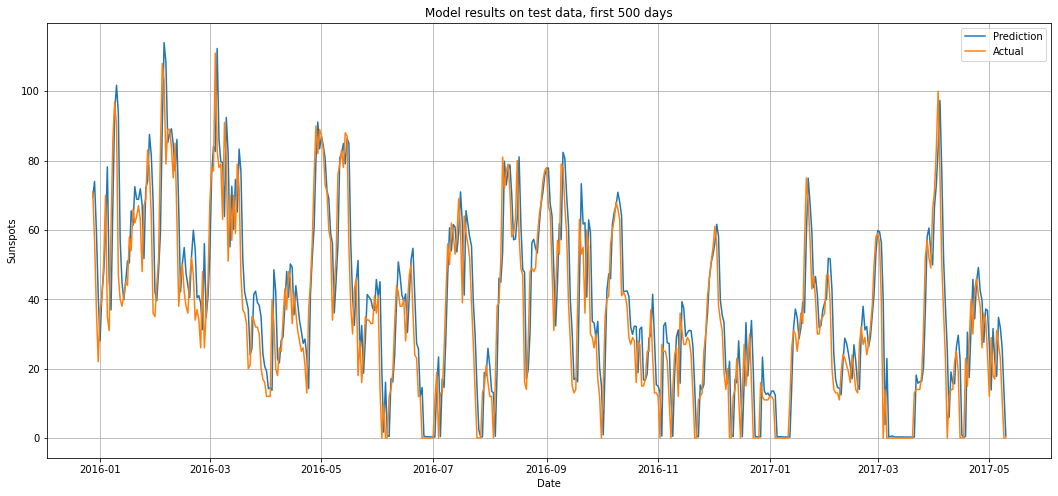

In [67]:
plot(test_results.iloc[:500], "Model results on test data, first 500 days")

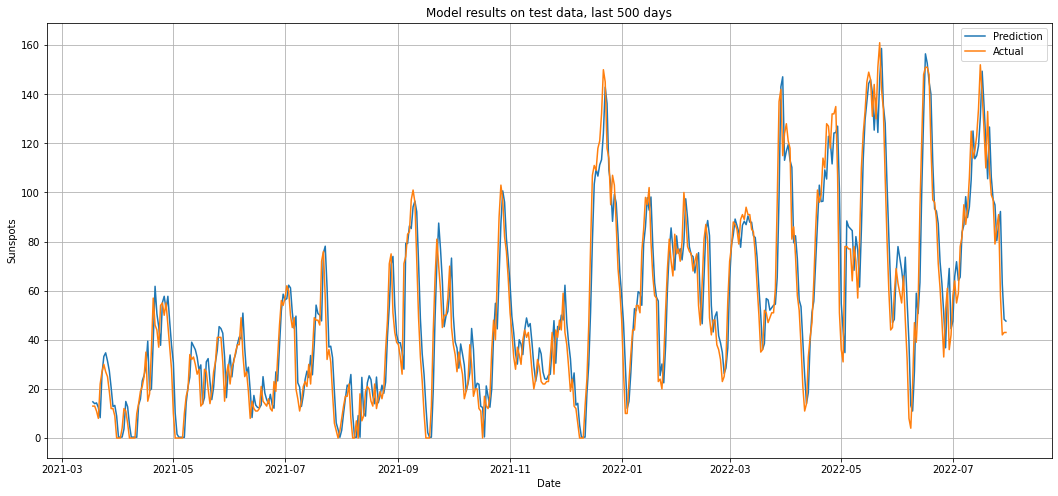

In [56]:
plot(test_results.iloc[-500:], "Model results on test data, last 500 days")

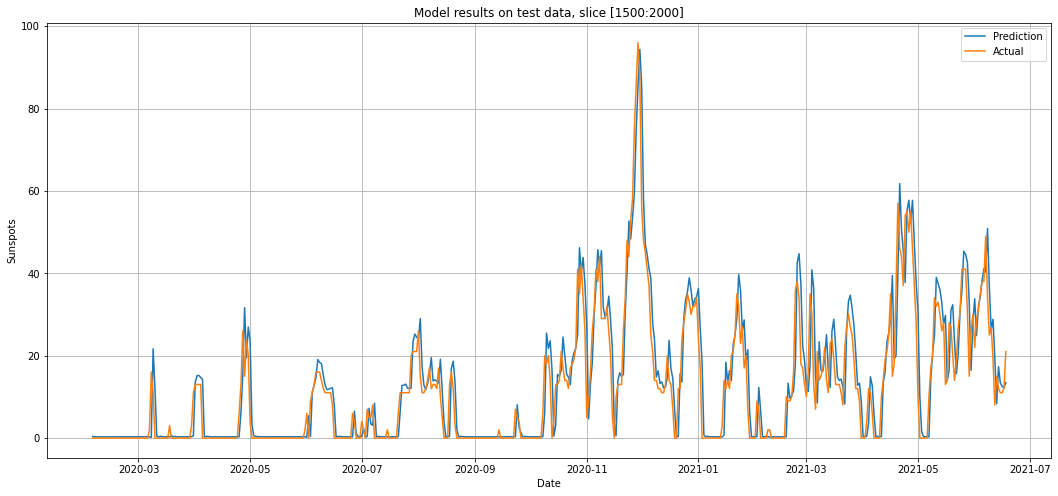

In [59]:
plot(test_results.iloc[1500:2000], "Model results on test data, slice [1500:2000]")

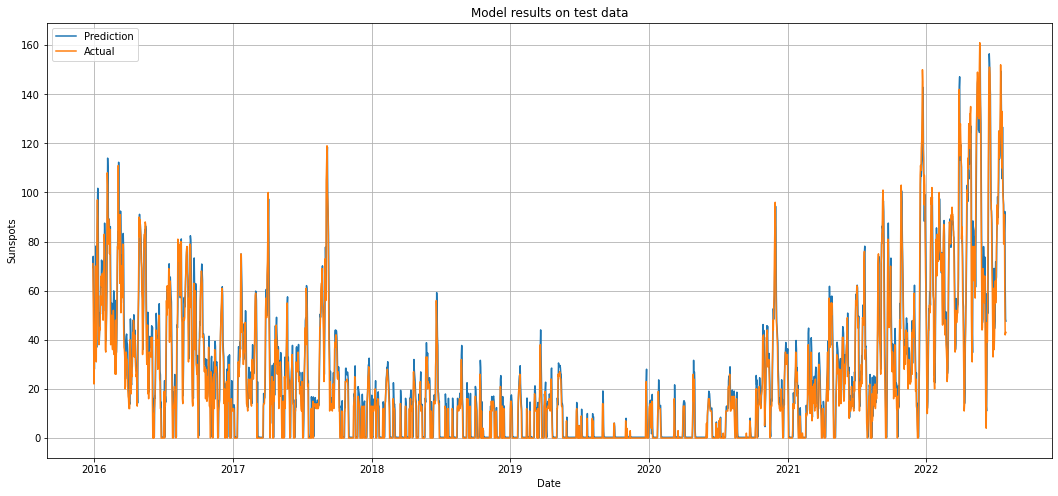

In [58]:
plot(test_results, "Model results on test data")

### Вывод

Получили модель, которая с ошибкой $RMSE\approx9.2$ предсказывает количество солнечных пятен в определенный день. 

О том, что модель хорошая, можно сказать, глядя на графики для тестовой выборки.